## Analyzing and fitting interferometric visibility datasets of circumstellar rings

Bringing your data from archive to paper-ready plots requires several steps, which we will follow and execute in this Notebook. Built in **Python 3 and with CASA 5.4.0**, but may handle other versions.

**GALARIO package**:
https://github.com/mtazzari/galario
**needs to be installed within local Python 3 installation**, e.g. with conda with a command like: 'conda install -c conda-forge galario'. This code was tested with version 1.2

**RADMC-3D version 0.41**:
http://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/index.html
comes with the package, in a version that has been slightly modified to avoid print statements if nothing goes wrong, and hence save time. **This however needs to be installed** through: 'cd radmc-gala/radmc-3d/version_0.41/srcnoprint' and then 'make'. It is strongly advised that the user familiarises themselves with the ray-tracing capabilities of radmc-3d, although this knowledge is not strictly needed to run radmc-gala.
The **radmc3dPy** add-on: https://www.ast.cam.ac.uk/~juhasz/radmc3dPyDoc/index.html is used to read radmc-3d files into Python, and is included within the radmc-3d package.

**Astropy**:
https://www.astropy.org/
**needs to be installed within local Python 3 installation**, to enable read and write of FITS format files. Installation is as simple as: 'conda install astropy' or 'pip install astropy'. This code was tested with version 3.0.4

**Tqdm**:
https://pypi.org/project/tqdm/
**needs to be installed within local Python 3 installation**, to enable a progress bar to appear during MCMC run.
Installation is as simple as: 'conda install -c conda-forge tqdm'. This code was tested with version 4.36.1

**Corner**:
https://corner.readthedocs.io/en/latest/
**needs to be installed within local Python 3 installation**, to enable production of corner plots.
Installation is as simple as: 'conda install -c astropy corner'. This code was tested with version 2.0.1

## Step 0: Create list with all requested inputs

Here you need to decide if you are doing imaging and/or fitting and/or 
input some parameters that are needed for the imaging and/or fitting and/or postprocessing.


In [1]:
import numpy as np
import os
import pickle

#Decide which you want to do, imaging and/or fitting and/or postprocessing
imaging=True
fit=True
postproc=True

radmcgalapath='/d1/boudica1/lmatra/radmc-gala'
casapath='/d1/boudica1/casa-release-5.4.0-68.el6/bin'
sourcetag='GJ14'
workingdir='/d1/boudica1/lmatra'
vis=['/sma/SMAusers/lmatra/REASONS_ALMA/cycle5/GJ14/calibratedms/GJ14_calibratedvis_cont.ms']
nvis=len(vis)
if not os.path.exists(workingdir+'/'+sourcetag):
    os.mkdir(workingdir+'/'+sourcetag)
    print('Creating directory for object '+sourcetag+' at '+workingdir)
else:
    print('Directory for object '+sourcetag+' already exists at '+workingdir)

if imaging:
    #Imaging parameters
    mosaic=False
    if mosaic:
        mosaic=True
        phasecenter='J2000 22h57m39.449700 -29d37m22.68681'
    else:
        phasecenter=''
    weighting='natural'
    if weighting=='briggs':
        robust=0.5
    else:
        robust=''
    uvtaper=['']
    interactive=True

if fit:
    #Parameters for fit
    Lstar=0.111  #Solar luminosities
    dist=14.7  #pc
    imsize=24.0     #arcsec, used for radiative transfer. >>2x belt outer radius, but not too large or it will slow down computation.
    #imsize above is also the size of the grid over which the model is setup in RADMC. No disk will be put beyond this.

    #Add disk parameters
    fluxdensity=1.8e-3 #Jy
    fluxdensity_dwn, fluxdensity_up = [0.1e-3, 50e-3]
    rmid=99.0/dist # Radial peak location of Gaussian surface density, arcsec
    rmid_dwn, rmid_up = [0.3, 12.0]
    sigma=32.0/2.35/dist #standard deviation of radial Gaussian surface density
    sigma_dwn, sigma_up = [0.05, 'halfrmid'] #halfrmid is special setup that enables maximum sigma to be half whatever rmid
    #is in current model evaluation.
    useh=True
    if useh:
        h=0.05 #aspect ratio of belt, constant with radius, whose vertical density structure at radius r is a Gaussian with width hr.
        h_dwn, h_up = [0.005, 0.2]
    else:
        h=0.03
    incl=65.0 #inclination, degrees from face-on
    incl_dwn, incl_up = [0.1, 89.99]
    posang=5.5 #position angle, East of North. **Needs to be between 0 and 180 degrees!**
    if posang<45.0 or posang>135.0:
        posang_dwn, posang_up = [-90.0, 90.0]
    else:
        posang_dwn, posang_up = [0.0, 180.0]
       
    
    #Add star if wanted/needed
    star=True
    if star:
        fstar=4e-5 #Jy
        fstar_dwn, fstar_up = [1e-6, 2e-3]
    
    #Add extra parameters independently for each of the visibility datasets.
    if nvis>1:
        dRA=[-0.07,0.1,0.1] #RA offset of star+disk from phase center of observations
        dRA_dwn=[-3.0,-3.0,-3.0]
        dRA_up=[3.0,3.0,3.0]
        dDec=[0.14,-0.1,-0.1] #Dec offset of star+disk from phase center of observations
        dDec_dwn=[-3.0,-3.0,-3.0]
        dDec_up=[3.0,3.0,3.0]
        wtfact=[0.289,0.289,1e-4] #factors by which incorrect weights should be multiplied by\
        wtfact_dwn=[1e-6,1e-6,1e-6]
        wtfact_up=[10.0,10.0,10.0]
    else:
        dRA=[-0.07] #RA offset of star+disk from phase center of observations
        dRA_dwn=[-3.0]
        dRA_up=[3.0]
        dDec=[0.14] #Dec offset of star+disk from phase center of observations
        dDec_dwn=[-3.0]
        dDec_up=[3.0]
        wtfact=[0.289] #factors by which incorrect weights should be multiplied by
        wtfact_dwn=[1e-6]
        wtfact_up=[10.0]

    #Add galaxies if needed
    ngal=0
    if ngal>=1:
        resolved=[True, False, False] # if definitely resolved, use 2D Gaussian as galaxy model (6 free parameters), and set resolved=True for that galaxy. 
    #Otherwise, use point source (3 free parameters) by setting resolved=False.
        fbkg=[285e-6,500e-6,500e-6] #Flux (Jy)
        fbkg_dwn=[1e-6,1e-6,1e-6]
        fbkg_up=[10e-3,10e-3,10e-3]
        dRAbkg=[2.97,2.97,2.97] # RA offset (")
        dRAbkg_dwn=[x-3.0 for x in dRAbkg]
        dRAbkg_up=[x+3.0 for x in dRAbkg]
        dDecbkg=[1.81,1.81,1.81] # Dec offset (")
        dDecbkg_dwn=[x-3.0 for x in dDecbkg]
        dDecbkg_up=[x+3.0 for x in dDecbkg]
        sigmagal=[0.3,0,0] # sigma (")
        sigmagal_dwn=[0.05,0.05,0.05]
        sigmagal_up=[1.0,1.0,1.0]
        PAgal=[28.0,0,0] # PA (deg), East of North. **Needs to be between 0 and 180 degrees!**
        PAgal_dwn=[]
        PAgal_up=[]
        for i in PAgal:
            if PAgal<45.0 or PAgal>135.0:
                PAgal_dwn.append(-90.0)
                PAgal_up.append(90.0)
            else:
                PAgal_dwn.append(0.0)
                PAgal_up.append(180.0)   
        incgal=[49.0,0,0] # inc (deg)
        incgal_dwn=[0.1,0.1,0.1]
        incgal_up=[89.99,89.99,89.99]
    else: 
        resolved=None
        fbkg=None
        dRAbkg=None
        dDecbkg=None
        sigmagal=None
        PAgal=None
        incgal=None
        
    #Now define array containing all initial parameters
    ## NB DO NOT MODIFY ORDER AS SETUP_MCMC CODE WILL NOT RECOGNISE PARAMETERS CORRECTLY
    pars_init=[fluxdensity, rmid, sigma, incl, posang]
    priors_dwn=[fluxdensity_dwn, rmid_dwn, sigma_dwn, incl_dwn, posang_dwn]
    priors_up=[fluxdensity_up, rmid_up, sigma_up, incl_up, posang_up]
    if useh:
        pars_init.append(h)
        priors_dwn.append(h_dwn)
        priors_up.append(h_up)
    if star:
        pars_init.append(fstar)
        priors_dwn.append(fstar_dwn)
        priors_up.append(fstar_up)
    for i in np.arange(nvis):
        pars_init.append(dRA[i])
        priors_dwn.append(dRA_dwn[i])
        priors_up.append(dRA_up[i])
        pars_init.append(dDec[i])
        priors_dwn.append(dDec_dwn[i])
        priors_up.append(dDec_up[i])
        pars_init.append(wtfact[i])
        priors_dwn.append(wtfact_dwn[i])
        priors_up.append(wtfact_up[i])
    if ngal>=1:
        for i in np.arange(ngal):
            pars_init.append(fbkg[i])
            priors_dwn.append(fbkg_dwn[i])
            priors_up.append(fbkg_up[i])
            pars_init.append(dRAbkg[i])
            priors_dwn.append(dRAbkg_dwn[i])
            priors_up.append(dRAbkg_up[i])
            pars_init.append(dDecbkg[i])
            priors_dwn.append(dDecbkg_dwn[i])
            priors_up.append(dDecbkg_up[i])
            if resolved[i]:
                pars_init.append(sigmagal[i])
                priors_dwn.append(sigmagal_dwn[i])
                priors_up.append(sigmagal_up[i])
                pars_init.append(PAgal[i])
                priors_dwn.append(PAgal_dwn[i])
                priors_up.append(PAgal_up[i])
                pars_init.append(incgal[i])
                priors_dwn.append(incgal_dwn[i])
                priors_up.append(incgal_up[i])



Directory for object GJ14 already exists at /d1/boudica1/lmatra


## Step 1: Create directory structure

In [2]:
print('Creating directory structure')
os.chdir(workingdir+'/'+sourcetag)

#Imaging
if imaging:
    print('Will be carrying out imaging')
    for i in ['calibratedms', 'imaging']:
        if not os.path.exists(workingdir+'/'+sourcetag+'/'+i):
            os.mkdir(workingdir+'/'+sourcetag+'/'+i)
    !cp -r {radmcgalapath}/utils/mstonumpyortxt_multiple.py {workingdir}/{sourcetag}/calibratedms/.
    for i in np.arange(len(vis)):
        if not os.path.exists('calibratedms/'+vis[i].rsplit('/',1)[1]):
            !cp -r {vis[i]} {workingdir}/{sourcetag}/calibratedms/.
        vis[i]=vis[i].rsplit('/',1)[1]
        #print(vis[i])
    !cp -r {radmcgalapath}/utils/imagingscript_multiple.py {workingdir}/{sourcetag}/imaging/.  
    #Save imaging parameters
    pickle.dump([sourcetag,workingdir,vis,nvis,mosaic,phasecenter,weighting,robust,uvtaper,interactive], open(workingdir+'/'+sourcetag+'/imaging/imagepars.npy', 'wb'), protocol=2)

    
#Fitting
if fit: 
    print('Will be carrying out visibility fit')
    if not os.path.exists(workingdir+'/'+sourcetag+'/'+'imaging'):
        sys.exit('Carry out imaging first: need .pb primary beam image')
    for i in ['uvfit']:
        if not os.path.exists(workingdir+'/'+sourcetag+'/'+i):
            os.mkdir(workingdir+'/'+sourcetag+'/'+i)
    !cp -r {radmcgalapath}/utils/setup_mcmc.py {workingdir}/{sourcetag}/uvfit/. 
    !cp -r {radmcgalapath}/utils/problem_setup_cont_gauss.py {workingdir}/{sourcetag}/uvfit/.  
    !cp -r {radmcgalapath}/utils/dustkappa_10445.micr.inp {workingdir}/{sourcetag}/uvfit/. 
    #Predict names of primary beam files according to standard naming convention
    pbfilenames=[[] for x in vis]
    for i in np.arange(nvis):
        if not imaging:
            vis[i]=vis[i].rsplit('/',1)[1]
        pbfilenames[i]=vis[i][:-3]+'_'+weighting+robust+'_pb.fits'
    #Save fit parameters
    pickle.dump([pbfilenames,vis,nvis,radmcgalapath,workingdir,sourcetag,Lstar,dist,imsize,useh,star
                 ,ngal,resolved, pars_init, priors_dwn, priors_up], open(workingdir+'/'+sourcetag+'/uvfit/fitpars.npy', 'wb'), protocol=2)

#Postprocessing
if postproc:
    if not (imaging or fit):
        print ('Will be carrying out postprocessing ONLY')
    else:
        print('Will be carrying out postprocessing')
    if not os.path.exists(workingdir+'/'+sourcetag+'/'+'uvfit'):
        sys.exit('Carry out fit before POSTprocessing!')
    for i in ['analysis', 'plots', 'uvfit/evaluation']:
        if not os.path.exists(workingdir+'/'+sourcetag+'/'+i):
            os.mkdir(workingdir+'/'+sourcetag+'/'+i)
    !cp -r {radmcgalapath}/utils/evaluatemodel_radmc3d.py {workingdir}/{sourcetag}/uvfit/. 
    !cp -r {radmcgalapath}/utils/uvresidualtoms.py {workingdir}/{sourcetag}/uvfit/. 
    !cp -r {radmcgalapath}/utils/makeuvdeprojplot_simple_multiple.py {workingdir}/{sourcetag}/uvfit/.
    !cp -r {radmcgalapath}/utils/plotimage.py {workingdir}/{sourcetag}/analysis/.  
    !cp -r {radmcgalapath}/utils/imagecombo.py {workingdir}/{sourcetag}/analysis/. 
   


Creating directory structure
Will be carrying out imaging
Will be carrying out visibility fit
Will be carrying out postprocessing
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/evaluatemodel_radmc3d.py': No such file or directory
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/uvresidualtoms.py': No such file or directory
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/makeuvdeprojplot_simple_multiple.py': No such file or directory
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/plotimage.py': No such file or directory
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/imagecombo.py': No such file or directory


## Step 2: Carry out imaging via imagingscript_multiple CASA script
First convert visibilities in CASA MS format to a python save file

In [3]:
os.chdir('calibratedms')
!{casapath}/casa -c mstonumpyortxt_multiple.py


The start-up time of CASA may vary
depending on whether the shared libraries
are cached or not.

]0;IPython: GJ14/calibratedmsIPython 5.1.0 -- An enhanced Interactive Python.

CASA 5.4.0-68   -- Common Astronomy Software Applications

--> CrashReporter initialized.
Found data with 225826 uv points per channel
with 1 channels per SPW and 2 polarizations,
8 SPWs and Channel 0 frequency of 1st SPW of 243.116401246 GHz
corresponding to 1.23311302102 mm
Datasets has baselines between 11.6500031801 and 371.63538144 m


Read in visibilities into Python, and use Galario to figure out ideal cell size and image size.
Typically half the suggested image size is OK.

In [4]:
from galario.double import get_image_size
u=[[] for x in vis]
v=[[] for x in vis]
Re=[[] for x in vis]
Im=[[] for x in vis]
w=[[] for x in vis]
nxy=[[] for x in vis]
dxy=[[] for x in vis]
for i in np.arange(nvis):
    u[i], v[i], Re[i], Im[i], w[i] = np.load(vis[i][:-3]+'.npy')
    nxy[i], dxy[i] = get_image_size(u, v)
    nxy[i]/=2
    print('Pixel size (arcsec) and number of pixels required for dataset '+vis[i]+':')
    print(dxy[i]*180.0/np.pi*3600, nxy[i])    

#Figure out pix size and number for concatenated image.
dxyall=np.min(dxy)
nxyall=np.int(np.ceil(np.max(np.asarray(dxy)*np.asarray(nxy))/dxyall/2.0)*2)
print('Pixel size (arcsec) and number of pixels that will be used:')
print(dxyall*180.0/np.pi*3600, nxyall)    


    
#Save pixel sizes and number of pixels, for imaging and fitting
pickle.dump([dxyall, np.int(nxyall)], open(workingdir+'/'+sourcetag+'/calibratedms/pixinfo.npy', 'wb'), protocol=2)


Pixel size (arcsec) and number of pixels required for dataset GJ14_calibratedvis_cont.ms:
0.06843568580635173 512.0
Pixel size (arcsec) and number of pixels that will be used:
0.06843568580635173 512


Then run the CLEANing using CASA's tclean.

Run this within CASA locally. There is no way around this if you want to use the interactive cleaning mode!

In [5]:
os.chdir('../imaging')
#THE COMMAND BELOW to be run on local computer for CASA to bring up interactive prompt:
#Within your terminal, go to the workingdir+sourcetag+'/imaging' folder, open CASA, and run:
execfile('imagingscript_multiple.py')

NameError: name 'execfile' is not defined

## Step 3: Run visibility fit by forward-modeling with RADMC-3D (ray tracing) and GALARIO (for FFT) through emcee package

Probably should define fit parameters here once we have seen the disk.

In [6]:
os.chdir('../uvfit')
newbackend=True
backendaddress='backend_'+sourcetag+'_todaysdate_computersname.pkl'
#np.save('backendaddress.npy', backendaddress)
pickle.dump(backendaddress, open('backendaddress.npy', 'wb'), protocol=2)


#print(np.load('backendaddress.npy'))
#!ls

#import setup_mcmc
%run -i setup_mcmc
nsteps=1000

#print(priors_up)
# This step actually starts the MCMC, at which point a progress bar should come up (may need installation of a python package).
# The MCMC runs for nsteps and starts the walkers for each parameter at position 'pos' defined above
sampler.run_mcmc(pos,nsteps,progress=True)
# If number of steps is insufficient, i.e. if the chains have not converged for each parameter, run for more steps using:
#sampler.run_mcmc(None,nsteps,progress=True)
# where nsteps is the number of steps you want to go further by.

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.
Setting up sampler...
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.88390633314438


  0%|          | 0/1000 [00:00<?, ?it/s]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.09391571461308
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.25332079413033


  0%|          | 1/1000 [00:09<2:43:49,  9.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.09282477211275
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.83502886061365
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 170.77865888379702


  0%|          | 2/1000 [00:19<2:41:31,  9.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.74327410295263
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 193.5884063353144


  0%|          | 3/1000 [00:28<2:39:57,  9.63s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.91244295676307
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.50138442812553
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.9298060381085
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.51668181899453
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 179.39438036967215


  0%|          | 4/1000 [00:38<2:39:54,  9.63s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 187.86072739722158
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.02744190483514
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.53482518576502


  0%|          | 5/1000 [00:47<2:38:04,  9.53s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 191.387215660373
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.160145142469
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.46894147147043
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.42431486193001


  1%|          | 6/1000 [00:56<2:36:58,  9.48s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.90220729795942
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.4458099471721


  1%|          | 7/1000 [01:06<2:35:12,  9.38s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.5111389344358
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.57253461745327


  1%|          | 8/1000 [01:15<2:34:40,  9.36s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 181.83445436602798
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.84235029025197


  1%|          | 9/1000 [01:24<2:34:43,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 176.8174817124814
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 176.36404512341372


  1%|          | 10/1000 [01:34<2:34:55,  9.39s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 179.60372988376756


  1%|          | 11/1000 [01:43<2:34:55,  9.40s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.34489252192213


  1%|          | 12/1000 [01:53<2:36:09,  9.48s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 194.88213978076826


  1%|▏         | 13/1000 [02:03<2:37:55,  9.60s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.90380266166437
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.95307168676203


  1%|▏         | 14/1000 [02:12<2:37:32,  9.59s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.88410933014003


  2%|▏         | 15/1000 [02:22<2:37:55,  9.62s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.69121901756506


  2%|▏         | 16/1000 [02:31<2:37:07,  9.58s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.82133133920792


  2%|▏         | 17/1000 [02:41<2:37:23,  9.61s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.93849327376552


  3%|▎         | 26/1000 [04:08<2:37:10,  9.68s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.88275966765733


  4%|▎         | 35/1000 [05:35<2:35:32,  9.67s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.053469968623


  4%|▎         | 37/1000 [05:53<2:30:56,  9.40s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.70525381353139


  4%|▍         | 41/1000 [06:31<2:30:58,  9.45s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.3940703154188


  4%|▍         | 43/1000 [06:49<2:29:27,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.31585947828367


  4%|▍         | 45/1000 [07:08<2:27:39,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.30371412792346
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.03797393936878


  5%|▍         | 46/1000 [07:17<2:28:35,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.73747141248907


  5%|▍         | 47/1000 [07:26<2:24:49,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.66077282451187


  5%|▍         | 48/1000 [07:35<2:25:21,  9.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.91535581454949


  5%|▍         | 49/1000 [07:44<2:26:03,  9.22s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.36304346621392


  5%|▌         | 51/1000 [08:03<2:26:10,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.2523633593881


  5%|▌         | 54/1000 [08:31<2:28:23,  9.41s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.67636583364452
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.4471747593976


  6%|▌         | 57/1000 [09:00<2:27:31,  9.39s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.912483042644


  6%|▌         | 59/1000 [09:19<2:28:27,  9.47s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.33842233539912


  6%|▌         | 60/1000 [09:28<2:28:10,  9.46s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.93263669961487
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.63106550559803
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.95973407466698


  6%|▌         | 62/1000 [09:47<2:26:47,  9.39s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.2008215126316
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.26347776087226
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.8459433929481


  6%|▋         | 63/1000 [09:56<2:25:00,  9.29s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.17858038254252
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.29446485217966


  6%|▋         | 64/1000 [10:05<2:24:07,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.89251677475067


  6%|▋         | 65/1000 [10:14<2:23:11,  9.19s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.75692976679798


  7%|▋         | 66/1000 [10:23<2:20:46,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.30540013995557
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.50458633912098


  7%|▋         | 67/1000 [10:31<2:19:15,  8.96s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.37723304249894


  7%|▋         | 68/1000 [10:41<2:20:59,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.601817710455
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.5637108967623
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.95838540122722


  7%|▋         | 69/1000 [10:50<2:19:42,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.10414774529897
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.72416329895333


  7%|▋         | 70/1000 [10:59<2:19:02,  8.97s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.23476923496995
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.38936392519622


  7%|▋         | 71/1000 [11:08<2:19:40,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.21688914052098
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.76580230488082


  7%|▋         | 72/1000 [11:17<2:19:15,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.3924799566027
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.93801991728174


  7%|▋         | 73/1000 [11:26<2:19:33,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.9305910817377


  7%|▋         | 74/1000 [11:35<2:19:29,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.33545283503594
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.04992999929007


  8%|▊         | 75/1000 [11:44<2:19:51,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.5497205406941


  8%|▊         | 76/1000 [11:53<2:19:47,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.68121862508968


  8%|▊         | 77/1000 [12:02<2:21:19,  9.19s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.3408857100512


  8%|▊         | 78/1000 [12:13<2:26:35,  9.54s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.02909255652014
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.2035243312917
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.17068852005926
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.45297377982067


  8%|▊         | 79/1000 [12:23<2:28:13,  9.66s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.48135583529648
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.79276212897847
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.99561338921745


  8%|▊         | 80/1000 [12:33<2:28:54,  9.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.5160870510208
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.0826827722991


  8%|▊         | 85/1000 [13:18<2:18:53,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.5620190472117
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.84311209110604


  9%|▊         | 86/1000 [13:27<2:17:03,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.09671595078333
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.24192980624377


  9%|▉         | 90/1000 [14:02<2:15:13,  8.92s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.16882181548522
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.95352676465504


  9%|▉         | 91/1000 [14:11<2:14:18,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.49774831854015


  9%|▉         | 92/1000 [14:20<2:14:21,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.20898515998988


  9%|▉         | 93/1000 [14:29<2:13:24,  8.83s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.86427479551975


  9%|▉         | 94/1000 [14:38<2:14:11,  8.89s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.6587397183101


 10%|▉         | 95/1000 [14:46<2:12:45,  8.80s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.27755091068803


 10%|▉         | 97/1000 [15:04<2:14:13,  8.92s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.2613387259772


 10%|█         | 100/1000 [15:30<2:11:25,  8.76s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.96363629499973


 10%|█         | 102/1000 [15:48<2:10:50,  8.74s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.9810423920817
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.16518448586532


 10%|█         | 103/1000 [15:56<2:11:16,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.54039615538167


 10%|█         | 105/1000 [16:13<2:07:48,  8.57s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.88074582065414


 11%|█         | 107/1000 [16:30<2:07:15,  8.55s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.3986781306099
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.83053046053305


 11%|█         | 108/1000 [16:39<2:07:07,  8.55s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.8257320831388


 11%|█         | 109/1000 [16:47<2:06:39,  8.53s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.38775718100015


 11%|█         | 110/1000 [16:55<2:04:41,  8.41s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.6510328796893


 11%|█         | 112/1000 [17:13<2:08:30,  8.68s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.09905653555273
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 170.25205316702835


 11%|█▏        | 113/1000 [17:23<2:11:29,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.57830299155233


 11%|█▏        | 114/1000 [17:31<2:10:11,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.04211135780633


 12%|█▏        | 115/1000 [17:40<2:09:36,  8.79s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.60274050852223
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.5665431355594


 12%|█▏        | 116/1000 [17:49<2:09:28,  8.79s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.58410377711112


 12%|█▏        | 118/1000 [18:07<2:11:00,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.52345713017604


 12%|█▏        | 119/1000 [18:16<2:10:24,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.67974653646144
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.51816342630383
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.9440322838549


 12%|█▏        | 120/1000 [18:24<2:09:35,  8.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.40868731404527


 12%|█▏        | 121/1000 [18:33<2:07:29,  8.70s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.6294854588154


 12%|█▏        | 122/1000 [18:42<2:09:36,  8.86s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.0326336926096


 12%|█▏        | 123/1000 [18:50<2:07:29,  8.72s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.74795887858895


 12%|█▏        | 124/1000 [18:59<2:05:07,  8.57s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.14854273092323


 13%|█▎        | 127/1000 [19:26<2:11:40,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.57151110849026


 13%|█▎        | 129/1000 [19:44<2:09:16,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.66859792394132


 13%|█▎        | 130/1000 [19:53<2:11:33,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.62139865146344


 13%|█▎        | 131/1000 [20:02<2:07:45,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.8124392534886
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.03067927617502


 14%|█▎        | 136/1000 [20:46<2:08:40,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.71824509823847


 14%|█▎        | 137/1000 [20:55<2:08:03,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.60810196065188


 14%|█▍        | 138/1000 [21:04<2:08:54,  8.97s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.66814326095795
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.48279892348575


 14%|█▍        | 139/1000 [21:13<2:10:18,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.44769042024254


 14%|█▍        | 141/1000 [21:31<2:10:16,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.84654514324595
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.41421413921964


 14%|█▍        | 142/1000 [21:41<2:14:46,  9.42s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.1254688449373
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.1523575599055


 14%|█▍        | 143/1000 [21:51<2:13:18,  9.33s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.89880430808313


 14%|█▍        | 144/1000 [21:59<2:09:42,  9.09s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.5393717863686


 14%|█▍        | 145/1000 [22:09<2:11:41,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.31246305730602
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.4015827037773


 15%|█▍        | 148/1000 [22:36<2:10:40,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.1152061455153
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.10253330662556


 15%|█▍        | 149/1000 [22:45<2:09:04,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.52475823600201


 15%|█▌        | 150/1000 [22:54<2:07:37,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 179.03557157903816


 15%|█▌        | 151/1000 [23:03<2:07:42,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.60511894398985
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.5286855205032
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.57581513035956


 15%|█▌        | 152/1000 [23:12<2:08:07,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.68673121936723


 15%|█▌        | 153/1000 [23:21<2:08:10,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.67875567946518


 16%|█▌        | 155/1000 [23:40<2:12:46,  9.43s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.04246281279444


 16%|█▌        | 156/1000 [23:49<2:08:18,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.07171853336695
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 178.28220232852993


 16%|█▌        | 157/1000 [23:58<2:08:00,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.17580271707408
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.95739845523903
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.73977727178047


 16%|█▌        | 159/1000 [24:17<2:09:50,  9.26s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.76960731575758


 16%|█▌        | 160/1000 [24:26<2:09:20,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.9751677100448


 16%|█▌        | 162/1000 [24:43<2:05:07,  8.96s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.6117668732391
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.22445434635665


 16%|█▋        | 163/1000 [24:52<2:05:15,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.9809159141389


 16%|█▋        | 165/1000 [25:10<2:04:09,  8.92s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.93167761888228
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 176.21363100279865


 17%|█▋        | 166/1000 [25:20<2:07:49,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.49002079806488
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.1836286826568


 17%|█▋        | 167/1000 [25:30<2:08:53,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.7555805857138


 17%|█▋        | 169/1000 [25:48<2:08:46,  9.30s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.95953913638724


 17%|█▋        | 171/1000 [26:07<2:09:26,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.79882159383328
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.59083285331167


 17%|█▋        | 174/1000 [26:35<2:08:53,  9.36s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.4592001581429


 17%|█▋        | 174/1000 [26:43<2:06:50,  9.21s/it]

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.86483820e-03  6.94428436e+00  1.02532245e+00  6.40854705e+01
  5.87958135e+00  6.27613529e-02  1.84753246e-05 -5.35672591e-02
  3.31168124e-02  2.88537545e-01]emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.78120964e-03  6

Traceback (most recent call last):


  exception:
  exception:


Traceback (most recent call last):


  exception:
  exception:


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


  exception:


Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 202, in lnpostfn
    imag     =     radmc3dPy.imag

FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 202, in lnpostfn
    imag     =     radmc3dPy.image.readImage(binary=True)
FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=4, dtype=int)
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 202, in lnpostfn
    imag     =     radmc3dPy.image.readImage(binary=True)
FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=4, dtype=int)
FileNotFoundError: [Errno 2] No such file or directory: 'image.

KeyboardInterrupt: 

Process ForkPoolWorker-11:
Process ForkPoolWorker-2:
Process ForkPoolWorker-16:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
Process ForkPoolWorker-14:
Process ForkPoolWorker-5:
Process ForkPoolWorker-15:
Process ForkPoolWorker-1:
Process ForkPoolWorker-13:
Process ForkPoolWorker-4:
Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self

  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/d1/boudica1/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File

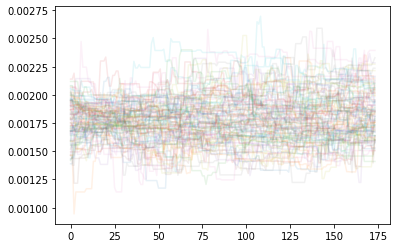

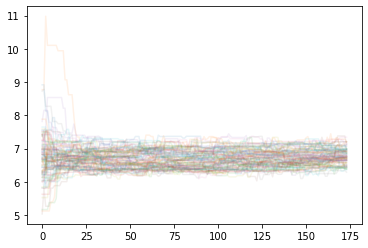

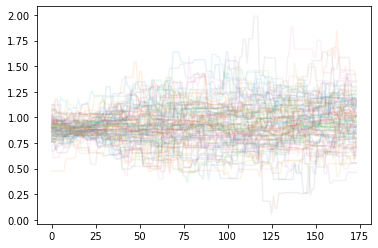

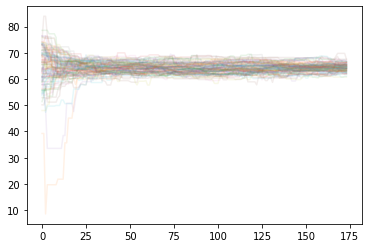

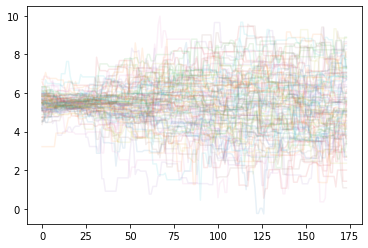

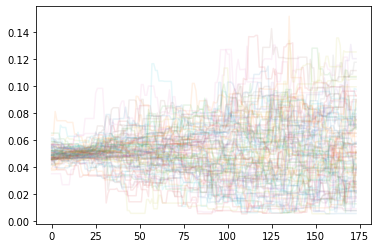

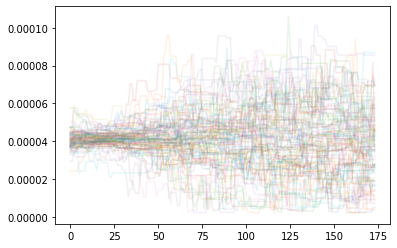

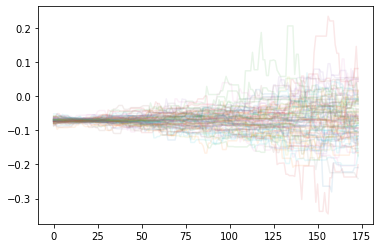

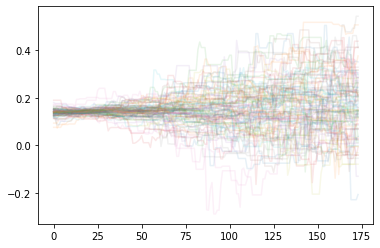

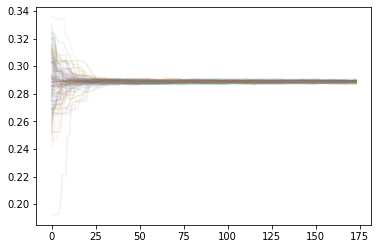

In [7]:
chain=backend.get_chain()
for j in range(chain.shape[2]):
    pl.figure()
    for i in range(chain.shape[1]):
        pl.plot(chain[:,i,j], alpha=0.1)

In [9]:
# If number of steps is insufficient, i.e. if the chains have not converged for each parameter, run for more steps using:
newbackend=False
%run -i setup_mcmc
sampler.run_mcmc(None,1000-chain.shape[0],progress=True)
# where nsteps is the number of steps you want to go further by.

Setting up sampler...


  0%|          | 0/826 [00:00<?, ?it/s]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.4592001581429


  0%|          | 1/826 [00:09<2:04:29,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.47435324639875


  0%|          | 3/826 [00:27<2:03:48,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.03722100591168


  1%|          | 5/826 [00:45<2:05:34,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.7791038394084


  1%|          | 6/826 [00:54<2:04:41,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.02489396035355


  1%|          | 7/826 [01:03<2:02:22,  8.96s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.03143381958964


  1%|          | 8/826 [01:12<2:04:24,  9.13s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 172.69644878437896
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.92082879455813


  1%|          | 9/826 [01:21<2:03:37,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.23799960357152


  1%|▏         | 12/826 [01:49<2:05:19,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.6609125744556


  2%|▏         | 13/826 [01:58<2:04:25,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.1224014838525


  2%|▏         | 15/826 [02:17<2:05:39,  9.30s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.11443963364545


  2%|▏         | 17/826 [02:35<2:03:34,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.97974848630486


  2%|▏         | 19/826 [02:52<2:00:15,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.39436144948434
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.2436938514607
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.65933559124983


  3%|▎         | 21/826 [03:12<2:05:39,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.02344837874003
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 179.56261021725595


  3%|▎         | 22/826 [03:21<2:05:39,  9.38s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.44803705581035


  3%|▎         | 23/826 [03:31<2:05:28,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.32521655721274


  3%|▎         | 24/826 [03:39<2:01:54,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.22881600101013


  3%|▎         | 25/826 [03:48<2:02:01,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.91594964320367


  3%|▎         | 26/826 [03:58<2:02:45,  9.21s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.40119649561186


  3%|▎         | 27/826 [04:07<2:02:08,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.44346900454264


  3%|▎         | 28/826 [04:16<2:01:12,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 176.04171726811558
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.0664733540428
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.54657445933694


  4%|▎         | 29/826 [04:25<2:00:32,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.3321580154261


  4%|▎         | 30/826 [04:34<1:59:48,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.80222563637201
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.65553477124197
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.13672011911194
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.98660775332445


  4%|▍         | 31/826 [04:43<2:01:04,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.87974345836074
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.5501101106092


  4%|▍         | 32/826 [04:52<1:59:09,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.12494159428002
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.65206833787417


  4%|▍         | 34/826 [05:11<2:03:23,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.878211504149


  4%|▍         | 35/826 [05:20<1:59:50,  9.09s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.73853954578334


  4%|▍         | 36/826 [05:28<1:57:16,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.6467260979433


  4%|▍         | 37/826 [05:37<1:56:44,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.39112097768916
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.22350029216284


  5%|▍         | 39/826 [05:55<1:58:12,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.07863889807498


  5%|▍         | 40/826 [06:04<1:56:10,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.29328322888196


  5%|▌         | 42/826 [06:21<1:55:59,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.09538407898978


  5%|▌         | 43/826 [06:31<1:57:11,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.5384819558925
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.56505718665554
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 175.29594972850253


  5%|▌         | 44/826 [06:39<1:56:07,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.62053216646538
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.41478783763583


  5%|▌         | 45/826 [06:48<1:55:45,  8.89s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.1759963159476
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.132796695232
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.37570100419936


  6%|▌         | 46/826 [06:58<1:57:31,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.66965609926393
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.29681843480893


  6%|▌         | 47/826 [07:06<1:55:57,  8.93s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.49371163418857
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 174.29997420335783


  6%|▌         | 48/826 [07:15<1:55:33,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.89361053720324
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.0522644144229


  6%|▌         | 50/826 [07:33<1:54:53,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.4093178599506
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.21432083416659


  6%|▌         | 51/826 [07:43<1:58:18,  9.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.7050706849155


  6%|▋         | 52/826 [07:52<1:59:18,  9.25s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.62972559916392
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.26149381537067


  6%|▋         | 53/826 [08:02<2:02:07,  9.48s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.57888078936304
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.71968888260218


  7%|▋         | 54/826 [08:12<2:02:39,  9.53s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.03541475433457


  7%|▋         | 55/826 [08:20<1:57:17,  9.13s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.7620206891642
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.58447566737965


  7%|▋         | 56/826 [08:29<1:56:15,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.1588902786222
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.94041617683428
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.4796358895312
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.9140066688781


  7%|▋         | 57/826 [08:38<1:56:41,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.69776339809562
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.91501288513035


  7%|▋         | 59/826 [08:55<1:52:48,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.1032538921904
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.1085702138111
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.27327962654212
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.85409188778254


  8%|▊         | 64/826 [09:39<1:51:23,  8.77s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.65308817395254


  8%|▊         | 65/826 [09:48<1:52:41,  8.89s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.75769785546584


  8%|▊         | 66/826 [09:57<1:53:29,  8.96s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.2623763491008
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.20174952099651


  8%|▊         | 67/826 [10:06<1:54:12,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.64705724442393


  8%|▊         | 68/826 [10:15<1:53:23,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.69379432508887


  8%|▊         | 70/826 [10:34<1:56:08,  9.22s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.9862181237578


  9%|▉         | 74/826 [11:10<1:52:04,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.50015568097308


  9%|▉         | 75/826 [11:18<1:50:54,  8.86s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.77040623446786


  9%|▉         | 76/826 [11:27<1:50:31,  8.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.5377998720864
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.10369859348052


  9%|▉         | 77/826 [11:36<1:52:11,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.65633206976213
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.5261624316487


 10%|▉         | 80/826 [12:03<1:52:20,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.69806763610507


 10%|█         | 84/826 [12:40<1:52:49,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.17574963540346


 10%|█         | 86/826 [12:58<1:51:30,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.96679200676513


 11%|█         | 89/826 [13:26<1:54:13,  9.30s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.52712359910163


 11%|█         | 91/826 [13:44<1:52:01,  9.15s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.18490811300842
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.10512456610883


 11%|█         | 92/826 [13:53<1:52:42,  9.21s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.07823027342312


 11%|█▏        | 93/826 [14:02<1:51:27,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.30513036083775


 12%|█▏        | 98/826 [14:48<1:52:54,  9.31s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.53553270446344


 12%|█▏        | 102/826 [15:23<1:46:58,  8.86s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.28916496276594


 12%|█▏        | 103/826 [15:32<1:46:37,  8.85s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.66155238193193


 13%|█▎        | 104/826 [15:40<1:46:48,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.6164794249279


 13%|█▎        | 105/826 [15:49<1:45:26,  8.77s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.2649800904671


 13%|█▎        | 107/826 [16:06<1:45:13,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.1651091659434


 14%|█▍        | 116/826 [17:24<1:44:45,  8.85s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.3675461033036


 14%|█▍        | 119/826 [17:50<1:40:48,  8.56s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.34487083964834
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.39287827073986


 15%|█▍        | 120/826 [17:59<1:43:15,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.98649858645467
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.70090649031656


 15%|█▍        | 123/826 [18:25<1:42:00,  8.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.92275280134683


 15%|█▌        | 126/826 [18:52<1:42:45,  8.81s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.16804662870058
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.03260873912018


 16%|█▌        | 129/826 [19:18<1:40:39,  8.66s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.4442163674851


 16%|█▌        | 132/826 [19:44<1:41:40,  8.79s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.80845438013228


 16%|█▋        | 135/826 [20:11<1:42:36,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.47617398850147
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.80412194569325


 17%|█▋        | 137/826 [20:30<1:46:01,  9.23s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.3348736640934


 17%|█▋        | 138/826 [20:40<1:46:23,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.81776535809416


 17%|█▋        | 139/826 [20:49<1:47:40,  9.40s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.20101132983143
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.40091632492684


 17%|█▋        | 140/826 [20:59<1:47:07,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.834697767645
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.4461101779511


 17%|█▋        | 143/826 [21:25<1:40:51,  8.86s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.9015551929499


 17%|█▋        | 144/826 [21:33<1:39:56,  8.79s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.2090889877647


 18%|█▊        | 145/826 [21:42<1:40:39,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.80562719566694


 18%|█▊        | 147/826 [21:59<1:38:14,  8.68s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.25427788972328
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.76436273136673
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.45745272131177


 18%|█▊        | 148/826 [22:09<1:40:39,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.71826708674863
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.50186890830477


 18%|█▊        | 149/826 [22:18<1:41:57,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.27725374754544
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.79869424814825


 18%|█▊        | 151/826 [22:36<1:42:10,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.07169183077795


 18%|█▊        | 152/826 [22:45<1:41:23,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 175.8828491873714


 19%|█▊        | 153/826 [22:54<1:41:27,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.64641358947873


 19%|█▉        | 156/826 [23:21<1:40:39,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.95570916923467


 19%|█▉        | 157/826 [23:30<1:39:55,  8.96s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.37787278158322
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.73399853293185


 19%|█▉        | 158/826 [23:38<1:37:35,  8.77s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.61372243746587


 19%|█▉        | 159/826 [23:47<1:38:44,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.55493369658438
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.9662174695087


 19%|█▉        | 160/826 [23:56<1:39:18,  8.95s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.99697523852728


 20%|██        | 168/826 [25:12<1:46:10,  9.68s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.72178905287709


 21%|██        | 170/826 [25:31<1:43:45,  9.49s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.5618252400826


 21%|██        | 174/826 [26:10<1:44:20,  9.60s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.6933766079929
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.4291325600214


 21%|██▏       | 176/826 [26:29<1:44:03,  9.60s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.80828372039488


 22%|██▏       | 179/826 [26:56<1:40:43,  9.34s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.67798749259475


 22%|██▏       | 180/826 [27:07<1:43:22,  9.60s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.2788479277691


 22%|██▏       | 182/826 [27:25<1:39:36,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.32974418990972


 22%|██▏       | 184/826 [27:42<1:36:57,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.80243996126376


 23%|██▎       | 186/826 [28:01<1:38:01,  9.19s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.90657793989797


 23%|██▎       | 187/826 [28:10<1:37:31,  9.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.51140871532849


 23%|██▎       | 188/826 [28:20<1:38:38,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.52998743039166


 23%|██▎       | 189/826 [28:29<1:37:50,  9.22s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.35092775773006


 23%|██▎       | 190/826 [28:38<1:36:55,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.97465459447176
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.5708936398097


 23%|██▎       | 191/826 [28:46<1:35:14,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.08267538819536


 23%|██▎       | 193/826 [29:04<1:33:17,  8.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.61883167054123


 23%|██▎       | 194/826 [29:12<1:31:45,  8.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.67472572189126


 24%|██▎       | 195/826 [29:21<1:32:50,  8.83s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.8903957433279


 24%|██▎       | 196/826 [29:30<1:32:57,  8.85s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 172.5021817170736
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.47186512834685


 24%|██▍       | 197/826 [29:39<1:34:24,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.65078184938682
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.34644918505577


 24%|██▍       | 198/826 [29:49<1:35:56,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.6072643988014
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.32874585837283


 24%|██▍       | 201/826 [30:16<1:35:03,  9.13s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.39477990607026


 24%|██▍       | 202/826 [30:25<1:34:51,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.43138388510266


 25%|██▍       | 205/826 [30:52<1:31:56,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.4023151885106


 25%|██▍       | 206/826 [31:01<1:31:28,  8.85s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.74897060448797


 25%|██▌       | 207/826 [31:09<1:31:26,  8.86s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.20300482953235


 25%|██▌       | 209/826 [31:26<1:29:18,  8.69s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.95813052272698
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.87204395445184


 25%|██▌       | 210/826 [31:35<1:29:39,  8.73s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.83006963456182


 26%|██▌       | 211/826 [31:44<1:30:56,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.47026377446184


 26%|██▌       | 214/826 [32:12<1:32:23,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.9309690956228


 27%|██▋       | 221/826 [33:16<1:31:18,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.92557251302316


 27%|██▋       | 222/826 [33:25<1:32:11,  9.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.36196157611508
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.0174554801776
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.41291424474042


 27%|██▋       | 224/826 [33:43<1:30:46,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.8267234439833


 27%|██▋       | 225/826 [33:52<1:31:45,  9.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.86924322635116


 27%|██▋       | 226/826 [34:02<1:31:47,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.71214416901105


 28%|██▊       | 233/826 [35:04<1:28:51,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.78781130540074
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.19595581640712


 28%|██▊       | 234/826 [35:14<1:30:14,  9.15s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.5150224599534


 29%|██▉       | 240/826 [36:08<1:28:47,  9.09s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.90865547227773


 30%|██▉       | 247/826 [37:11<1:27:28,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.63708735218756


 30%|███       | 248/826 [37:20<1:25:27,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.37724401539543


 30%|███       | 250/826 [37:38<1:26:31,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.21808274998003


 32%|███▏      | 264/826 [39:49<1:30:16,  9.64s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.79788293754


 33%|███▎      | 269/826 [40:38<1:29:36,  9.65s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.51317502188485


 33%|███▎      | 272/826 [41:05<1:24:59,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.48123711153485


 33%|███▎      | 276/826 [41:43<1:25:44,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.73660088402949


 34%|███▎      | 278/826 [42:02<1:24:01,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.07055462952493


 34%|███▍      | 282/826 [42:39<1:23:38,  9.23s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.23154003232565
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.3414893192957


 35%|███▍      | 287/826 [43:24<1:21:41,  9.09s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.32799027283997


 35%|███▍      | 288/826 [43:34<1:21:31,  9.09s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.68595975966903


 35%|███▌      | 292/826 [44:10<1:20:20,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.41521664862316


 36%|███▌      | 295/826 [44:37<1:19:21,  8.97s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.75510565951757


 36%|███▌      | 296/826 [44:46<1:21:05,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.83121741624603


 36%|███▌      | 299/826 [45:15<1:21:59,  9.33s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.34121002688363
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.07721416224044


 37%|███▋      | 304/826 [46:00<1:18:11,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.0485311240712
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.09710514607315


 37%|███▋      | 306/826 [46:17<1:16:03,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.859623631151


 38%|███▊      | 310/826 [46:53<1:17:33,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.08315449172846
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.07704230326053


 38%|███▊      | 311/826 [47:02<1:17:37,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.4246667201693


 38%|███▊      | 315/826 [47:38<1:16:27,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.39014878485318


 38%|███▊      | 316/826 [47:47<1:15:57,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.48221564046986


 38%|███▊      | 318/826 [48:04<1:15:10,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.86778403554317


 39%|███▊      | 319/826 [48:13<1:15:09,  8.89s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.62962942955141


 39%|███▉      | 321/826 [48:30<1:13:32,  8.74s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.18622783622007
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.6567183144213


 39%|███▉      | 323/826 [48:49<1:16:10,  9.09s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.3442201624444


 40%|███▉      | 328/826 [49:36<1:16:05,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.0940444596556


 40%|████      | 332/826 [50:11<1:13:23,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.00780223589783


 40%|████      | 333/826 [50:20<1:13:50,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.56254914047386


 41%|████      | 335/826 [50:39<1:15:08,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.89375034586524


 41%|████      | 339/826 [51:17<1:15:53,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.25855920728048


 42%|████▏     | 344/826 [52:04<1:15:54,  9.45s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.05649827555982


 42%|████▏     | 347/826 [52:32<1:14:38,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.86701027759526


 42%|████▏     | 349/826 [52:50<1:13:15,  9.21s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 174.84065969230215


 43%|████▎     | 352/826 [53:18<1:12:48,  9.22s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.39698023877747


 43%|████▎     | 353/826 [53:27<1:12:44,  9.23s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.83352149856438


 43%|████▎     | 355/826 [53:46<1:14:05,  9.44s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.73403849984706


 43%|████▎     | 357/826 [54:04<1:12:07,  9.23s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.29859893209084


 44%|████▍     | 364/826 [55:10<1:10:46,  9.19s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.3231568559127


 44%|████▍     | 365/826 [55:19<1:09:11,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.511340744528
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.20147236394348


 44%|████▍     | 366/826 [55:28<1:09:58,  9.13s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.9930548854257


 45%|████▍     | 368/826 [55:48<1:11:52,  9.42s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.569257519404


 45%|████▍     | 370/826 [56:06<1:11:03,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.20214428832867


 45%|████▌     | 372/826 [56:25<1:10:43,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.73224662231306
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.16146081600607


 45%|████▌     | 374/826 [56:44<1:09:52,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.18009838961999


 45%|████▌     | 375/826 [56:52<1:09:02,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.57313838212843


 46%|████▌     | 378/826 [57:19<1:06:28,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.84299686358526


 46%|████▌     | 379/826 [57:28<1:07:22,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.22243129487384
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.00380322723936


 46%|████▌     | 380/826 [57:38<1:07:45,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.67333057940115


 46%|████▌     | 381/826 [57:47<1:09:02,  9.31s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.31012209350072
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 185.16179814004653


 46%|████▋     | 383/826 [58:06<1:08:14,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.42766815386213


 46%|████▋     | 384/826 [58:14<1:07:21,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.25555518695333


 47%|████▋     | 385/826 [58:23<1:06:16,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.42062824188864


 47%|████▋     | 386/826 [58:32<1:05:52,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.03721705924903


 48%|████▊     | 396/826 [1:00:00<1:03:36,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.12935701494428


 48%|████▊     | 400/826 [1:00:35<1:01:53,  8.72s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.28642547392496


 49%|████▉     | 403/826 [1:01:03<1:03:58,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.41039326573983


 49%|████▉     | 404/826 [1:01:12<1:05:06,  9.26s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.26751993566177


 49%|████▉     | 405/826 [1:01:22<1:06:25,  9.47s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.14359097352065


 50%|█████     | 413/826 [1:02:37<1:03:17,  9.19s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.51636180306264


 50%|█████     | 417/826 [1:03:13<1:01:26,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.98677469705098


 51%|█████     | 418/826 [1:03:22<1:02:07,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.75447396408993


 51%|█████     | 419/826 [1:03:32<1:02:36,  9.23s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.21786948168997
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.7456780512848


 51%|█████     | 421/826 [1:03:50<1:01:58,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.35445091590987


 51%|█████     | 422/826 [1:03:59<1:00:48,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.7934629020806


 51%|█████     | 423/826 [1:04:09<1:01:57,  9.23s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.24003940889713
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.19727330643013


 51%|█████▏    | 424/826 [1:04:18<1:03:05,  9.42s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.67763670619183


 52%|█████▏    | 427/826 [1:04:48<1:03:42,  9.58s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.74061924766147


 52%|█████▏    | 428/826 [1:04:57<1:03:12,  9.53s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.49161864405733


 52%|█████▏    | 430/826 [1:05:17<1:04:56,  9.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.97711189405655


 52%|█████▏    | 432/826 [1:05:36<1:02:43,  9.55s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.88771300017063
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.37938750545175


 53%|█████▎    | 436/826 [1:06:14<1:01:03,  9.39s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.66161427654706


 53%|█████▎    | 437/826 [1:06:23<1:00:45,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.7604796024938


 53%|█████▎    | 439/826 [1:06:43<1:02:16,  9.65s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.3443516610261
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.10622628477392


 53%|█████▎    | 440/826 [1:06:52<1:02:11,  9.67s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.77001486933315


 54%|█████▍    | 444/826 [1:07:31<1:01:13,  9.62s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.17279109122705


 54%|█████▍    | 445/826 [1:07:41<1:01:47,  9.73s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.8333466015652


 54%|█████▍    | 446/826 [1:07:50<59:06,  9.33s/it]  

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.13155283719166


 54%|█████▍    | 447/826 [1:07:59<58:29,  9.26s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.8322418013062
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.10837957377575


 54%|█████▍    | 448/826 [1:08:07<56:47,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.57081196359843


 54%|█████▍    | 449/826 [1:08:17<59:02,  9.40s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.70483788866002


 54%|█████▍    | 450/826 [1:08:26<57:30,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.15411371907396
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.94756531735362


 55%|█████▍    | 454/826 [1:09:04<57:58,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.01731974750015


 55%|█████▌    | 455/826 [1:09:13<57:12,  9.25s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.86832294159612


 55%|█████▌    | 456/826 [1:09:22<57:10,  9.27s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.34117682596656


 56%|█████▌    | 459/826 [1:09:50<57:03,  9.33s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.12663685876097


 56%|█████▌    | 460/826 [1:09:59<55:56,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.45348119061606


 56%|█████▌    | 461/826 [1:10:07<54:47,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.4941589190966
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.48824360364472


 57%|█████▋    | 467/826 [1:11:02<55:21,  9.25s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.31711384254857
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.52123312810912


 57%|█████▋    | 468/826 [1:11:11<53:54,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.35365871159215


 57%|█████▋    | 470/826 [1:11:29<53:21,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.0799036998077


 57%|█████▋    | 471/826 [1:11:38<53:17,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.0965149039963


 57%|█████▋    | 472/826 [1:11:47<53:50,  9.13s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.4797015164637


 57%|█████▋    | 473/826 [1:11:57<54:51,  9.32s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.93006222932954
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.31047066112365


 57%|█████▋    | 474/826 [1:12:06<53:48,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.9834208874242
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.73235150516135


 58%|█████▊    | 477/826 [1:12:34<54:23,  9.35s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.7918991461874


 58%|█████▊    | 479/826 [1:12:53<53:42,  9.29s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.15175638790473
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.73726731536703
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.44943617886256
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.79488024495132
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.51935565192295


 58%|█████▊    | 480/826 [1:13:02<54:12,  9.40s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.91797074742715
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.69300598734225


 58%|█████▊    | 481/826 [1:13:11<53:08,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.79623981161785


 58%|█████▊    | 483/826 [1:13:28<50:56,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.1068653082768
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.9441946007398


 59%|█████▊    | 484/826 [1:13:37<50:38,  8.89s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.25781748044494


 59%|█████▊    | 485/826 [1:13:46<50:44,  8.93s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.51194873774554
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.92228688902856


 59%|█████▉    | 486/826 [1:13:56<51:23,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.71035880478746
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.6456493693705
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.65933069535973


 59%|█████▉    | 487/826 [1:14:05<51:10,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.32266781312748
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 170.9281515374259


 59%|█████▉    | 488/826 [1:14:13<50:34,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.44740707211037
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.60858034787964
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.17229594415824
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.57091050422957


 59%|█████▉    | 489/826 [1:14:22<50:26,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.16536813010893


 59%|█████▉    | 491/826 [1:14:40<49:20,  8.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.0243674407461
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.14029333157242
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.84312288954084


 60%|█████▉    | 494/826 [1:15:06<48:52,  8.83s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.9526650587726
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.6845836198865


 60%|█████▉    | 495/826 [1:15:16<49:37,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.16288313864834


 60%|██████    | 497/826 [1:15:34<49:54,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.23521640672126
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:


 60%|██████    | 497/826 [1:15:42<50:06,  9.14s/it]

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:


KeyboardInterrupt: 

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 2.06573199e-03  6.45544847e+00  1.18145163e+00  6.28435970e+01
  4.05644232e+00  6.42140791e-02  4.22205120e-05 -1.66822942e-01
  1.28975214e-01  2.88977807e-01]emcee: Exception while calling your likelihood function:
  params: [ 1.55207785e-03  6.28794077e+00  5.63192679e-01  6.01307976e+01
  5.58201792e+00  8.78469567e-02  6.30801693e-05 -4.96445452e-02
  4.16661763e-01  2.88723679e-01]

FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 1.96946863e-03  6.42827546e+00  9.71722978e-01  6.20670477e+01
  6.72075247e+00  8.48962841e-02  3.50589246e-05 -1.82634779e-01
  1.24473975e-01  2.88697095e-01]  params: [2.04302863e-03 6.91837628e+00 1.17321423e+00 6.42264573e+01
 5.06779820e+00 9.83508503e-03 2.33812249e-05 2.64746258e-03
 2.84908012e-01 2.87804337e-01]  params: [ 1.96710413e-03  6.60640646e+00  1.15603419e+00  6.32529113e+01
  1.12053577e+00  5.04330953e-02  3.07222327e-05 -1.47284085e-01
  1.42855418e-01  2.89550046e-01]  params: [ 2.31724388e-03  6.37109328e+00  8.49433808e-01  6.07958455e+01
  9.56759393e+00  1.21935881e-01  7.97468226e-05 -1.75348645e-01
 -3.27601147e-01  2.89678693e-01]  params: [ 1.87026051e-03  6.82877896e+00  1.07363649e+00  6.49043139e+01
  4.60802483e+00  3.24386683e-02  3.10585670e-05 -1.58828620e-01
  5.49303265e-02  2.89043768e-01]
  params: [ 2.81864625e-03  7.

Traceback (most recent call last):


  exception:


Traceback (most recent call last):


  kwargs: {}


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 202, in lnpostfn
    imag     =     radmc3dPy.image.readImage(binary=True)


  exception:


  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/

  kwargs: {}


  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 202, in lnpostfn
    imag     =     radmc3dPy.image.readImage(binary=True)
KeyboardInterrupt
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=4, dtype=int)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=

  exception:


  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=4, dtype=int)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=4, dtype=int)
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
Traceback (most recent call last):
FileNotFoundError: [Errno 2] No such file or directory: 'image.bout'
  File "/d1/boudica1/lmatra/radmc

emcee: Exception while calling your likelihood function:
  params: [ 2.09722193e-03  6.63671535e+00  1.16622540e+00  6.34119478e+01
  6.61588776e+00  3.74612844e-02  4.28631988e-05 -1.11269558e-01
  1.86901728e-01  2.88141014e-01]emcee: Exception while calling your likelihood function:

  args: []
  params: [ 1.50418010e-03  6.71405848e+00  8.69027865e-01  6.40358698e+01
  5.56199786e+00  2.39857085e-02  4.62998163e-05 -7.01453061e-02
  3.22207433e-01  2.88637125e-01]  kwargs: {}

  exception:
  args: []


Traceback (most recent call last):


  kwargs: {}
  exception:


  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 225, in lnpostfn
    , dRA=dRArad[i], dDec=dDecrad[i])
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/emcee/emcee3/ensemble.py", line 487, in __call__
    return self.f(x, *self.args, **self.kwargs)
KeyboardInterrupt
  File "/d1/boudica1/lmatra/GJ14/uvfit/setup_mcmc.py", line 202, in lnpostfn
    imag     =     radmc3dPy.image.readImage(binary=True)
Process ForkPoolWorker-23:
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 1111, in readImage
    dum.readImage(fname=fname, binary=binary, old=old)
Traceback (most recent call last):
  File "/d1/boudica1/lmatra/radmc-gala/radmc-3d/version_0.41/python/radmc3dPy/image.py", line 724, in readImage
    dum = np.fromfile(fname, count=4, dtype=int)
  File "/d1/boudica1/anaconda3/lib

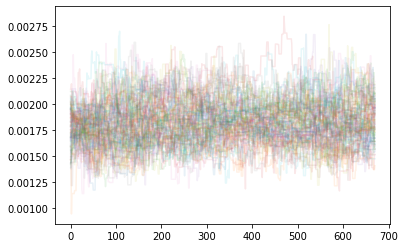

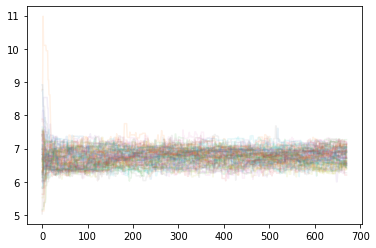

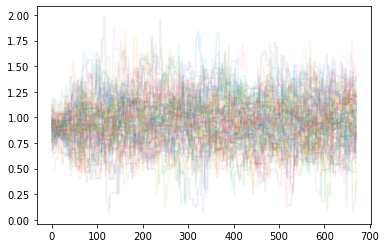

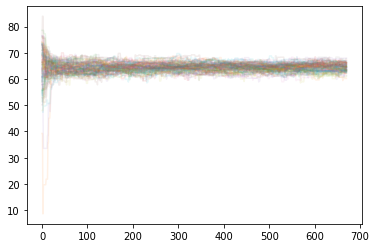

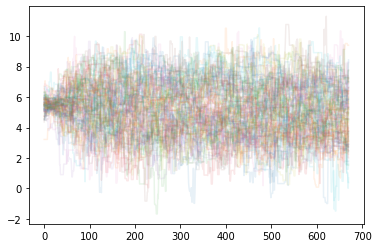

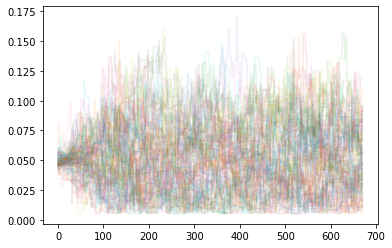

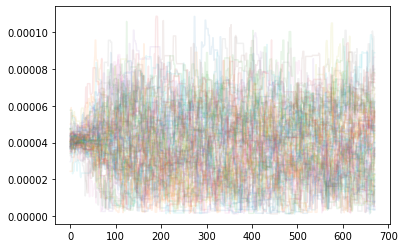

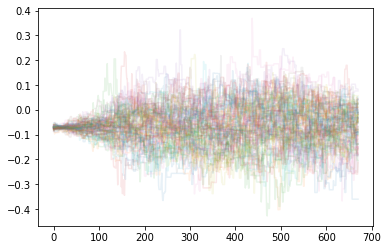

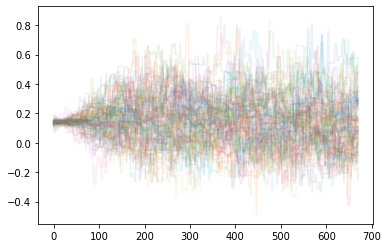

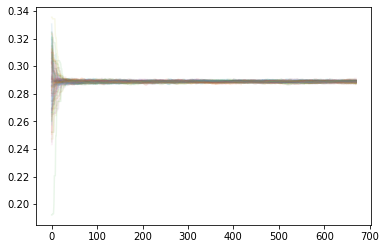

In [10]:
chain=backend.get_chain()
for j in range(chain.shape[2]):
    pl.figure()
    for i in range(chain.shape[1]):
        pl.plot(chain[:,i,j], alpha=0.1)

In [11]:
# If number of steps is insufficient, i.e. if the chains have not converged for each parameter, run for more steps using:
newbackend=False
%run -i setup_mcmc
sampler.run_mcmc(None,1000-chain.shape[0],progress=True)
# where nsteps is the number of steps you want to go further by.

Setting up sampler...


  0%|          | 0/329 [00:00<?, ?it/s]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.23521640672126


  0%|          | 1/329 [00:09<51:13,  9.37s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.1718520836048


  1%|          | 2/329 [00:19<51:49,  9.51s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.88979511948668
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.25645726616193


  1%|          | 3/329 [00:28<51:06,  9.41s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.80394948997434


  1%|          | 4/329 [00:37<50:02,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.7428180556559
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.82700637977524
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.31910896828396


  2%|▏         | 5/329 [00:46<50:26,  9.34s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.96074915606727


  2%|▏         | 7/329 [01:04<48:54,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.0227137719093


  3%|▎         | 9/329 [01:24<51:21,  9.63s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.23015468257637
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.0303583758452


  3%|▎         | 10/329 [01:34<51:26,  9.67s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.57373290917482


  4%|▎         | 12/329 [01:53<50:34,  9.57s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.308058258718


  5%|▍         | 15/329 [02:20<48:20,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.17884888626756


  5%|▌         | 17/329 [02:39<48:10,  9.27s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.6261432364869


  5%|▌         | 18/329 [02:48<47:00,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.58953773241217


  6%|▌         | 19/329 [02:57<47:30,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.36387723742936


  6%|▌         | 20/329 [03:06<46:26,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.47978733353608


  6%|▋         | 21/329 [03:15<47:09,  9.19s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.96790959691594
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.84894850733005


  7%|▋         | 23/329 [03:34<47:38,  9.34s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.56858816123574
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.99157661048156


  8%|▊         | 25/329 [03:54<49:02,  9.68s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.65555904176205
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.4234474459537


 10%|▉         | 32/329 [05:03<48:40,  9.83s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.68285859195285


 10%|█         | 33/329 [05:13<49:34, 10.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.0843899758902


 11%|█         | 35/329 [05:34<50:14, 10.25s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.7740068584307


 11%|█         | 36/329 [05:45<50:16, 10.29s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.57427774145432


 12%|█▏        | 38/329 [06:04<48:48, 10.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.3171047502967


 12%|█▏        | 39/329 [06:14<48:30, 10.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.71497409872327
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.87766101713632


 12%|█▏        | 41/329 [06:35<48:45, 10.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.76638583824297


 13%|█▎        | 42/329 [06:46<49:51, 10.42s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.88798079744336


 13%|█▎        | 43/329 [06:55<47:39, 10.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.91553011016694
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 170.50508213214857


 13%|█▎        | 44/329 [07:05<47:13,  9.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.61733434545846
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.08104171338493
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.7095142953746


 14%|█▎        | 45/329 [07:14<46:22,  9.80s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 175.69108981259694
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.78741815106508


 14%|█▍        | 46/329 [07:25<47:25, 10.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.67414930504145
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.72166535559478
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.78001391704208


 14%|█▍        | 47/329 [07:34<45:50,  9.75s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 192.16701452545706
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.90325683638025


 15%|█▍        | 48/329 [07:44<46:21,  9.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.96785727279243
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.8555769110432
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.49970786738388


 15%|█▍        | 49/329 [07:53<44:49,  9.60s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.33431210682286
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.30568060644922


 15%|█▌        | 50/329 [08:01<43:10,  9.29s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.30276931149467
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.247266137101


 16%|█▌        | 51/329 [08:10<42:33,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.87177677791624


 16%|█▌        | 52/329 [08:19<41:52,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.87870327225255
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.796706447506


 16%|█▌        | 53/329 [08:29<42:04,  9.15s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.8826659280445


 16%|█▋        | 54/329 [08:38<41:52,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.46681356489515


 17%|█▋        | 55/329 [08:46<41:11,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.33687663625597
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.68883097138328
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.97150354225664


 17%|█▋        | 56/329 [08:55<40:23,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 170.889854654333
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.24331144803472
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.0162626528992
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.6333556144096


 17%|█▋        | 57/329 [09:03<39:05,  8.62s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.89950273785337
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.0355443364839


 18%|█▊        | 58/329 [09:11<38:47,  8.59s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 176.9007519173699
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.5346805274537


 18%|█▊        | 59/329 [09:20<38:35,  8.58s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.19381102107423
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.22303642610706


 18%|█▊        | 60/329 [09:28<38:10,  8.51s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.49568774304836
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.00292331307844


 19%|█▊        | 61/329 [09:37<38:04,  8.52s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.10792081797666


 19%|█▉        | 63/329 [09:55<38:40,  8.72s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.87872751337943
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.00349003173778


 20%|█▉        | 65/329 [10:12<37:57,  8.63s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.98058963772
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.88864159495938


 20%|██        | 66/329 [10:21<38:40,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.0153726229616
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.3039224934503
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.6851754830205


 20%|██        | 67/329 [10:30<38:56,  8.92s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.96095649940125


 21%|██        | 68/329 [10:39<38:12,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.69817350911097
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.69026719686488


 21%|██        | 69/329 [10:48<38:46,  8.95s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 178.12287277784665


 21%|██▏       | 70/329 [10:57<38:37,  8.95s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.24564927162655
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.92660942711848


 22%|██▏       | 71/329 [11:06<38:01,  8.84s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.08738927079142


 22%|██▏       | 73/329 [11:23<37:21,  8.75s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.10161303206576
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.5558405414327
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.22583249497904


 22%|██▏       | 74/329 [11:32<36:53,  8.68s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.7222607625199
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.5969632610167


 23%|██▎       | 75/329 [11:40<36:53,  8.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.0433093479721
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.76460169458483


 23%|██▎       | 76/329 [11:49<36:44,  8.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.96078467985242


 23%|██▎       | 77/329 [11:58<36:25,  8.67s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.04736189107518


 24%|██▎       | 78/329 [12:06<36:02,  8.61s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.04346833318806
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.94932916504933
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 178.9806456334512
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.2699641148555


 24%|██▍       | 79/329 [12:15<36:27,  8.75s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.84415573335386
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.07839209361273
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.1200179688103


 24%|██▍       | 80/329 [12:25<37:03,  8.93s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.29054959589655


 25%|██▍       | 81/329 [12:34<37:24,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.1700399569483


 25%|██▍       | 82/329 [12:43<36:37,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.35042667167642
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.7362579562327


 25%|██▌       | 83/329 [12:52<37:39,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.3302491857446
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.15882536537293


 26%|██▌       | 86/329 [13:20<37:35,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.24354919065755


 26%|██▋       | 87/329 [13:29<37:05,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.90360058807838


 27%|██▋       | 88/329 [13:39<37:13,  9.27s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.50342253916253


 27%|██▋       | 89/329 [13:49<37:47,  9.45s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.06564278648318


 27%|██▋       | 90/329 [13:58<37:10,  9.33s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.67567040081323
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 170.4087092747472


 28%|██▊       | 91/329 [14:06<36:20,  9.16s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.78497442160696


 28%|██▊       | 92/329 [14:16<36:14,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.14459427267676
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.9519408640619


 28%|██▊       | 93/329 [14:25<36:12,  9.20s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.8891072628309


 29%|██▊       | 94/329 [14:34<35:49,  9.15s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.02001603503618


 29%|██▉       | 96/329 [14:52<35:05,  9.04s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 167.8733105003634


 29%|██▉       | 97/329 [15:01<35:00,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.9326415643899


 30%|██▉       | 98/329 [15:09<34:16,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.90783838298915


 31%|███       | 101/329 [15:36<33:26,  8.80s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.84110815588642
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.58623556737876


 31%|███▏      | 103/329 [15:54<33:27,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.2140197763364
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.02899045710774


 32%|███▏      | 104/329 [16:03<33:28,  8.93s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.6521729303925
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.36048090302168


 32%|███▏      | 105/329 [16:12<33:28,  8.97s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.4912663738607
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.1818037363542


 33%|███▎      | 107/329 [16:29<32:48,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.880294704323


 33%|███▎      | 108/329 [16:38<32:30,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.8613485742528


 33%|███▎      | 110/329 [16:55<31:13,  8.55s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.07538598612837
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.7115863470471


 34%|███▎      | 111/329 [17:03<30:40,  8.44s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.33992253429938


 35%|███▍      | 115/329 [17:37<30:12,  8.47s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.56348168211895


 35%|███▌      | 116/329 [17:45<30:01,  8.46s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.5290755508139
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.20802545143974


 36%|███▌      | 118/329 [18:01<29:14,  8.32s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.77313837141008


 36%|███▌      | 119/329 [18:10<29:48,  8.51s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.51164165115918
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.79520654781538


 37%|███▋      | 121/329 [18:27<29:31,  8.51s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.55994049095577


 37%|███▋      | 122/329 [18:36<29:29,  8.55s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.8338286296484
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.411948852541


 38%|███▊      | 124/329 [18:52<28:23,  8.31s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.1196350860199
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.1392022579746


 38%|███▊      | 125/329 [19:01<28:41,  8.44s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.55630445138837
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.0760235028036


 38%|███▊      | 126/329 [19:09<27:56,  8.26s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.232563085543
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.3952985879576


 39%|███▉      | 128/329 [19:26<28:25,  8.48s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.42029237646892


 40%|███▉      | 130/329 [19:44<28:30,  8.60s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.81284093769563


 40%|███▉      | 131/329 [19:52<28:39,  8.69s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.16066456751528


 40%|████      | 132/329 [20:01<28:34,  8.70s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.31662199684985


 40%|████      | 133/329 [20:10<28:31,  8.73s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.795329862319
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.26523956638312


 41%|████      | 135/329 [20:27<27:53,  8.63s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.4781794536293


 42%|████▏     | 138/329 [20:54<27:55,  8.77s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.77077072367274
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.9323965727404


 43%|████▎     | 140/329 [21:11<27:36,  8.77s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.1874269835647


 43%|████▎     | 141/329 [21:20<27:49,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.65026015758605


 44%|████▍     | 144/329 [21:46<27:06,  8.79s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.7051570831655


 46%|████▌     | 151/329 [22:48<25:59,  8.76s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.93804071875655


 47%|████▋     | 153/329 [23:06<25:51,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.90442087361157


 47%|████▋     | 154/329 [23:14<25:35,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.76558985427175


 47%|████▋     | 155/329 [23:24<25:54,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.28876574953304
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.35797316745118


 47%|████▋     | 156/329 [23:33<25:48,  8.95s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.69829202615946


 48%|████▊     | 157/329 [23:42<25:36,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.22937648626652


 49%|████▉     | 161/329 [24:17<25:04,  8.96s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.354025772576


 50%|████▉     | 163/329 [24:34<24:05,  8.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.68536554952397
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.79408595500774


 50%|████▉     | 164/329 [24:43<24:01,  8.74s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.56471687127024


 50%|█████     | 165/329 [24:52<23:52,  8.74s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.32325528630878


 53%|█████▎    | 173/329 [26:03<23:24,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.61596523668806


 53%|█████▎    | 175/329 [26:21<23:05,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.44304457411823


 53%|█████▎    | 176/329 [26:30<23:00,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.16721631755135


 54%|█████▍    | 177/329 [26:39<23:05,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.38470772177615


 55%|█████▍    | 180/329 [27:06<21:50,  8.80s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.68886845618255


 55%|█████▌    | 182/329 [27:24<21:59,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.3152725274279


 56%|█████▌    | 183/329 [27:33<21:54,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.96551645012644


 56%|█████▌    | 185/329 [27:51<21:32,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.1640015692144


 57%|█████▋    | 189/329 [28:27<21:13,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.25006631331485


 58%|█████▊    | 192/329 [28:54<20:46,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.64214289159773


 59%|█████▊    | 193/329 [29:03<20:34,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.83851875291182


 59%|█████▉    | 194/329 [29:12<20:26,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.89070099180194
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.15225942227062


 59%|█████▉    | 195/329 [29:21<20:13,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 186.5261500073989


 60%|█████▉    | 196/329 [29:30<19:49,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.24133100339753
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.62928867093694


 60%|█████▉    | 197/329 [29:39<19:44,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.31549009174228
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.53043229722007
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.53952753064883


 60%|██████    | 198/329 [29:48<19:43,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.32315589211973


 60%|██████    | 199/329 [29:57<19:22,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.13581743942618


 61%|██████    | 200/329 [30:06<19:06,  8.88s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.8393879885428
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.92238471245517


 61%|██████    | 201/329 [30:15<19:00,  8.91s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.00353587143076


 61%|██████▏   | 202/329 [30:24<18:54,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.6014398895842
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.24717610828122
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.19789921103126


 62%|██████▏   | 204/329 [30:41<18:43,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.9832220589086
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 174.76855440056096


 62%|██████▏   | 205/329 [30:51<18:41,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.08374051016818
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.36645189650025


 63%|██████▎   | 206/329 [31:00<18:34,  9.06s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.82420689344897


 63%|██████▎   | 207/329 [31:09<18:15,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 173.752890408926
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.12011422428068
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.23081720013465


 63%|██████▎   | 208/329 [31:18<18:17,  9.07s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 168.33450126723736


 64%|██████▎   | 209/329 [31:27<18:12,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.61253963362796


 64%|██████▍   | 210/329 [31:36<17:55,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.87445936330556


 64%|██████▍   | 211/329 [31:45<17:55,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.03685472354755
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.51071369752535
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.18677195192143


 65%|██████▍   | 213/329 [32:03<17:35,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.2647770751828


 65%|██████▌   | 214/329 [32:13<17:31,  9.15s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.9873499955322


 65%|██████▌   | 215/329 [32:22<17:35,  9.26s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.39956644133343


 66%|██████▌   | 216/329 [32:31<17:16,  9.17s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.04195419847554


 67%|██████▋   | 219/329 [32:59<16:53,  9.21s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.46076658534324


 67%|██████▋   | 221/329 [33:17<16:27,  9.15s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.20691230785513
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.7051037958174


 68%|██████▊   | 223/329 [33:35<16:07,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.76022406927095
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.00960480127296
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.08544079901213


 68%|██████▊   | 224/329 [33:45<16:11,  9.26s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.80377599833187


 68%|██████▊   | 225/329 [33:54<16:04,  9.27s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.50505685120504


 69%|██████▊   | 226/329 [34:04<16:02,  9.34s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.1879951886341


 70%|██████▉   | 229/329 [34:32<15:28,  9.28s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.4102337284854


 70%|██████▉   | 230/329 [34:40<15:01,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.6163315979854


 70%|███████   | 231/329 [34:49<14:55,  9.13s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.48679485525048


 71%|███████   | 233/329 [35:08<14:50,  9.27s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.51916441908665


 72%|███████▏  | 236/329 [35:35<14:07,  9.11s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.73020446858635


 73%|███████▎  | 239/329 [36:02<13:34,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.86621667592033


 74%|███████▍  | 243/329 [36:37<12:24,  8.65s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.26474701701207
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.965661076414
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.2466942886004


 74%|███████▍  | 244/329 [36:45<12:20,  8.71s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.56162630599098


 75%|███████▍  | 246/329 [37:04<12:29,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.36014949927173
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.75064938236085


 75%|███████▌  | 247/329 [37:13<12:19,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.09583647799332
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.1567929256328


 75%|███████▌  | 248/329 [37:22<12:03,  8.93s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.77092959280293
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.3324156609051
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.91625113691293
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 169.07383344879383


 76%|███████▌  | 249/329 [37:31<11:59,  9.00s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.77512508436288


 76%|███████▋  | 251/329 [37:49<11:35,  8.92s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.18048559892074
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.0559878871992


 77%|███████▋  | 252/329 [37:57<11:22,  8.87s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.66958832698379
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.36276918796108
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.81497298235684
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.83177748338315


 77%|███████▋  | 253/329 [38:07<11:25,  9.02s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.47016834719523


 77%|███████▋  | 254/329 [38:16<11:17,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.1308209889466


 78%|███████▊  | 255/329 [38:24<10:58,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.90189873005127
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.3367367628067


 78%|███████▊  | 256/329 [38:33<10:44,  8.83s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.4427845498404


 78%|███████▊  | 258/329 [38:51<10:26,  8.82s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.73796352096434
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.92621510323605


 79%|███████▊  | 259/329 [38:59<10:12,  8.75s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.9331364193502


 80%|███████▉  | 263/329 [39:35<09:50,  8.95s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 171.66285252540803


 81%|████████  | 266/329 [40:02<09:23,  8.94s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.91202388660633


 83%|████████▎ | 272/329 [40:55<08:22,  8.81s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.32195009982144
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.1841824474367


 84%|████████▎ | 275/329 [41:21<07:54,  8.78s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.50824618684467


 84%|████████▍ | 277/329 [41:40<07:46,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.89212109326257
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.6140047424599


 85%|████████▌ | 280/329 [42:07<07:20,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.38490014374645
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.55741718316105


 85%|████████▌ | 281/329 [42:15<07:07,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.04184327017873
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.1127710444561
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.9905982114885


 86%|████████▌ | 282/329 [42:25<07:04,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.40809063885933
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.6614717799186


 86%|████████▌ | 283/329 [42:33<06:50,  8.93s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.50125336901323
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.9459983819595


 86%|████████▋ | 284/329 [42:42<06:42,  8.95s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.14368566056237
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.4153851649789


 87%|████████▋ | 285/329 [42:51<06:29,  8.86s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 163.933181375233


 87%|████████▋ | 286/329 [43:00<06:26,  8.98s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.05051885978094
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 162.27451412220336


 87%|████████▋ | 287/329 [43:09<06:11,  8.85s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.5899713019791


 88%|████████▊ | 288/329 [43:18<06:04,  8.90s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.82174331497913
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.7503966121004


 88%|████████▊ | 289/329 [43:27<05:59,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.36362194540274
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.94706763772757


 88%|████████▊ | 290/329 [43:37<05:56,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.5813219678455


 89%|████████▉ | 294/329 [44:13<05:17,  9.08s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.24376832625484


 90%|████████▉ | 296/329 [44:31<04:57,  9.01s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.2579515827008


 90%|█████████ | 297/329 [44:40<04:45,  8.92s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 165.84908762406474


 91%|█████████ | 299/329 [44:58<04:31,  9.03s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.15130624407513
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.3701722656262


 91%|█████████ | 300/329 [45:07<04:20,  8.99s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 153.6435092948429
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.5782431716272


 91%|█████████▏| 301/329 [45:16<04:15,  9.14s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.67104602897513
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.29658814453705


 92%|█████████▏| 303/329 [45:34<03:55,  9.05s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 174.26121210653923


 93%|█████████▎| 305/329 [45:53<03:40,  9.18s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.83252004016688


 95%|█████████▍| 312/329 [46:59<02:42,  9.56s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.76250989895647
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.66810306359704
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.61696026433125
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 166.30958413310572


 95%|█████████▌| 314/329 [47:19<02:24,  9.62s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.4519943729081
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 161.51167082858092
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 158.2614081829996


 96%|█████████▌| 315/329 [47:28<02:12,  9.50s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.30908512333133
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.33742614020872


 96%|█████████▋| 317/329 [47:46<01:51,  9.32s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 155.62505993018166


 97%|█████████▋| 318/329 [47:55<01:41,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.34260332792266


 97%|█████████▋| 320/329 [48:13<01:21,  9.10s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 154.549623222146
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 160.0071317688605


 98%|█████████▊| 322/329 [48:31<01:03,  9.12s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.90357205228833


 98%|█████████▊| 323/329 [48:41<00:55,  9.24s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 157.6219780218049


 99%|█████████▉| 327/329 [49:18<00:18,  9.39s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.11809300840656
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 156.1625908667719


100%|█████████▉| 328/329 [49:27<00:09,  9.31s/it]

WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 159.29271891127877
WARNING - Grid may not be big enough. Max radius set to 153.46808510638297 but outer 2sigma of Gaussian ring is 164.39450321991842


100%|██████████| 329/329 [49:36<00:00,  9.05s/it]


(array([[ 1.85084959e-03,  6.72649178e+00,  7.19402177e-01,
          6.41801148e+01,  4.44187618e+00,  9.62172211e-02,
          8.51687584e-06,  3.53605194e-02,  1.09537140e-01,
          2.88572267e-01],
        [ 1.98829388e-03,  6.99183401e+00,  1.32962482e+00,
          6.47791893e+01,  2.92744954e+00,  8.85747982e-02,
          5.60241858e-05, -1.93980691e-01,  3.22495967e-01,
          2.89200333e-01],
        [ 1.96252474e-03,  6.75996897e+00,  1.16207867e+00,
          6.34689401e+01,  6.47187171e+00,  5.76905444e-02,
          6.75476156e-05, -5.61765169e-02,  2.13074966e-01,
          2.89233637e-01],
        [ 1.76421346e-03,  7.17090223e+00,  1.13232084e+00,
          6.58486626e+01,  6.90733564e+00,  4.59820208e-02,
          4.86048717e-05,  1.52197500e-01,  1.49743033e-02,
          2.89974000e-01],
        [ 1.87153068e-03,  7.09483896e+00,  8.34230735e-01,
          6.66424095e+01,  5.70679211e+00,  8.32104414e-02,
          5.69768147e-05, -5.77530697e-02,  2.624261

Text(0.5, 0, 'sampling')

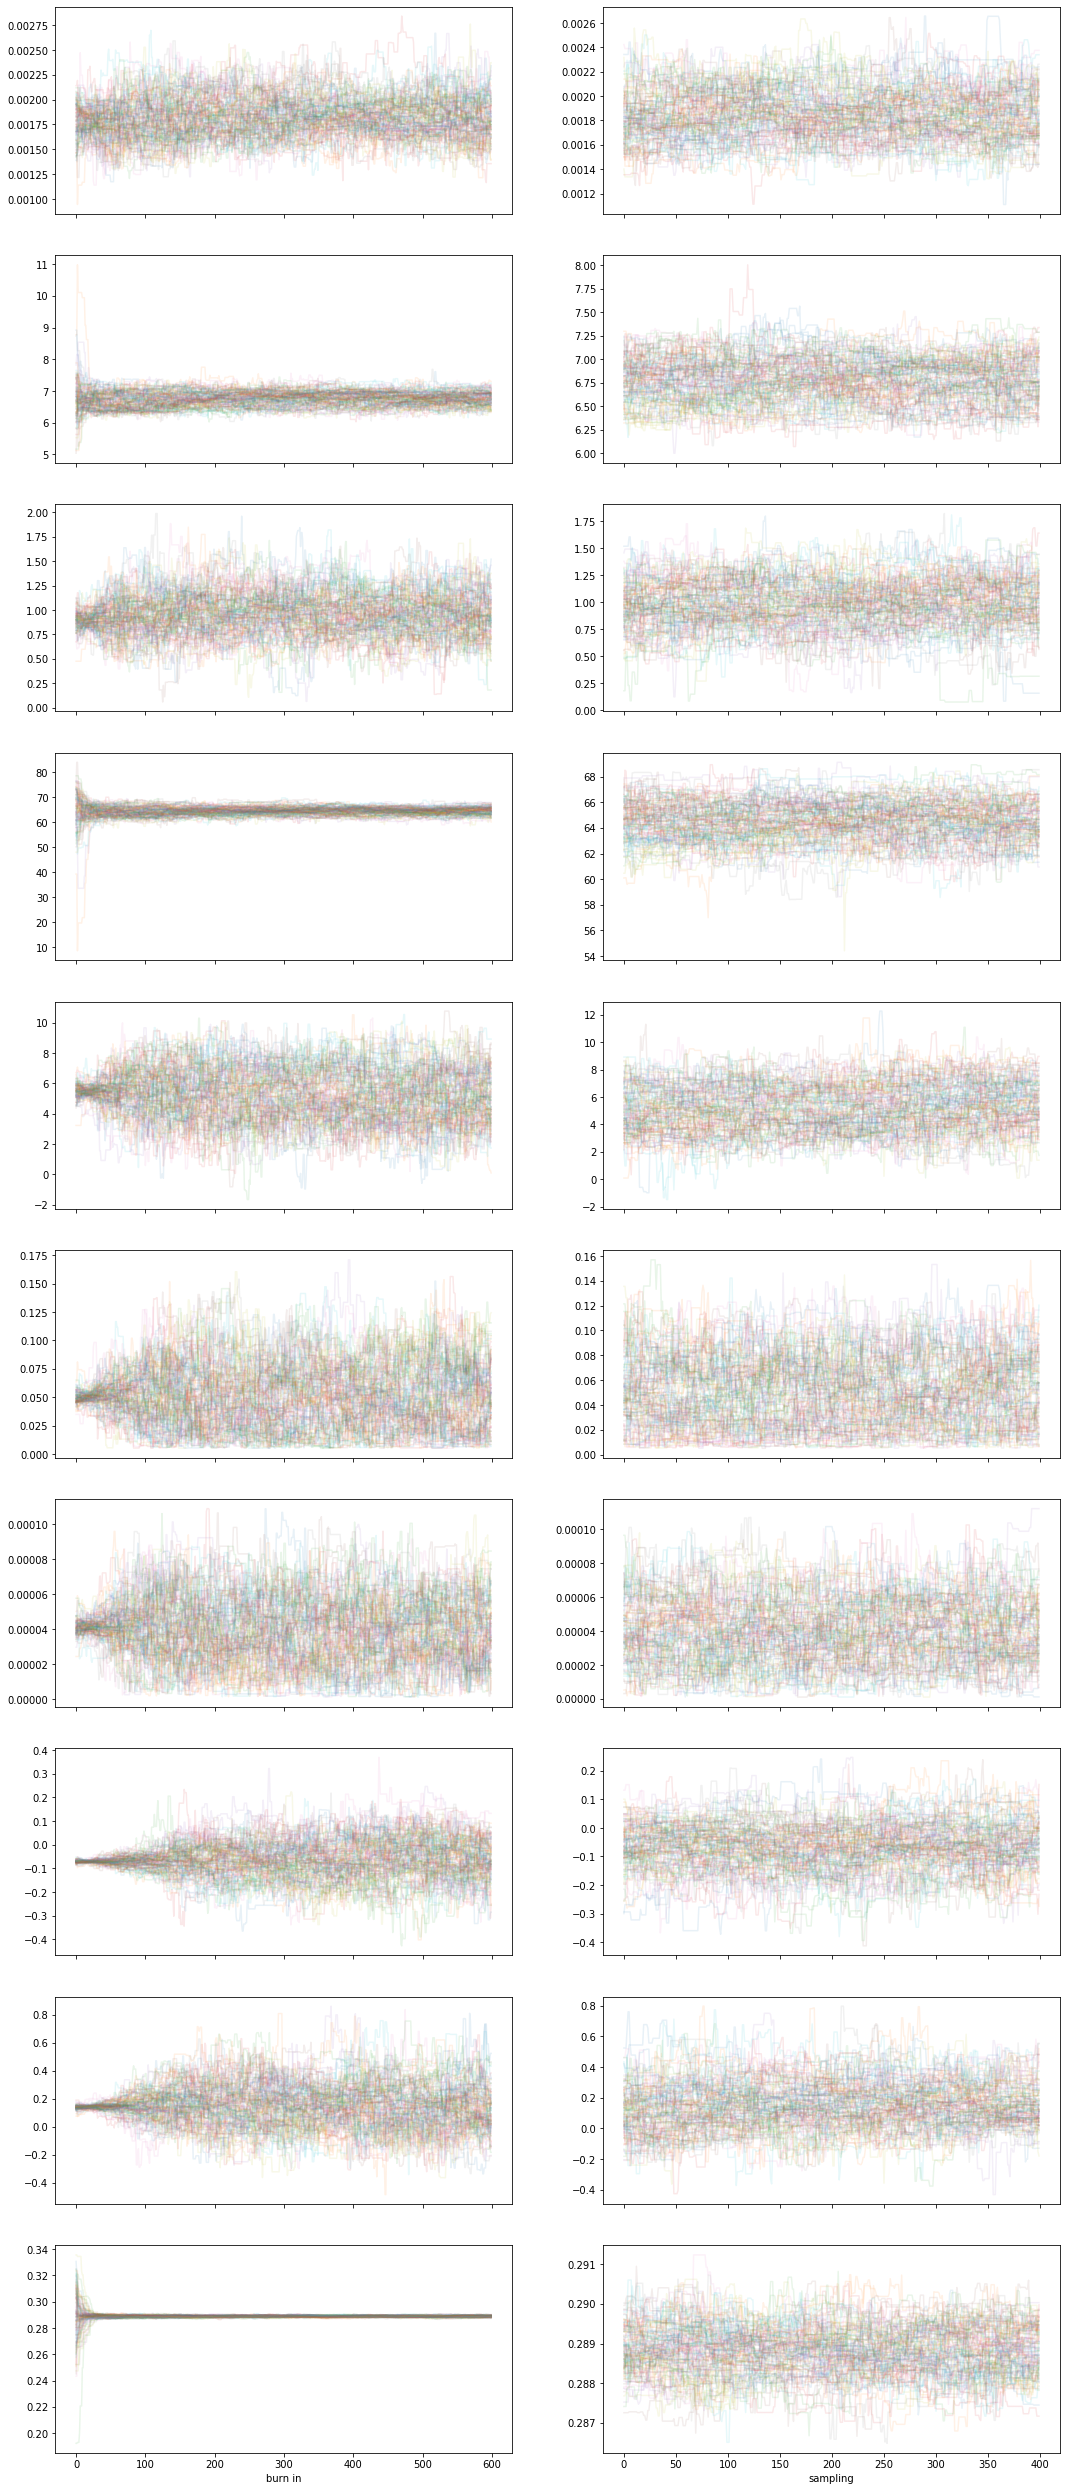

In [15]:
burn=600
# Trace plots
fig,ax = pl.subplots(ndim,2,figsize=(18,45),sharex='col',sharey=False)
for j in range(chain.shape[1]):
    #ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(chain.shape[2]):
        ax[i,0].plot(chain[:burn,j,i], alpha=0.1)
        #ax[i,0].set_ylabel(labelparams[i])

for j in range(chain.shape[1]):
    #ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(chain.shape[2]):
        ax[i,1].plot(chain[burn:,j,i], alpha=0.1)
        #ax[i,1].set_ylabel(labelparams[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')

/d1/boudica1/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/d1/boudica1/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


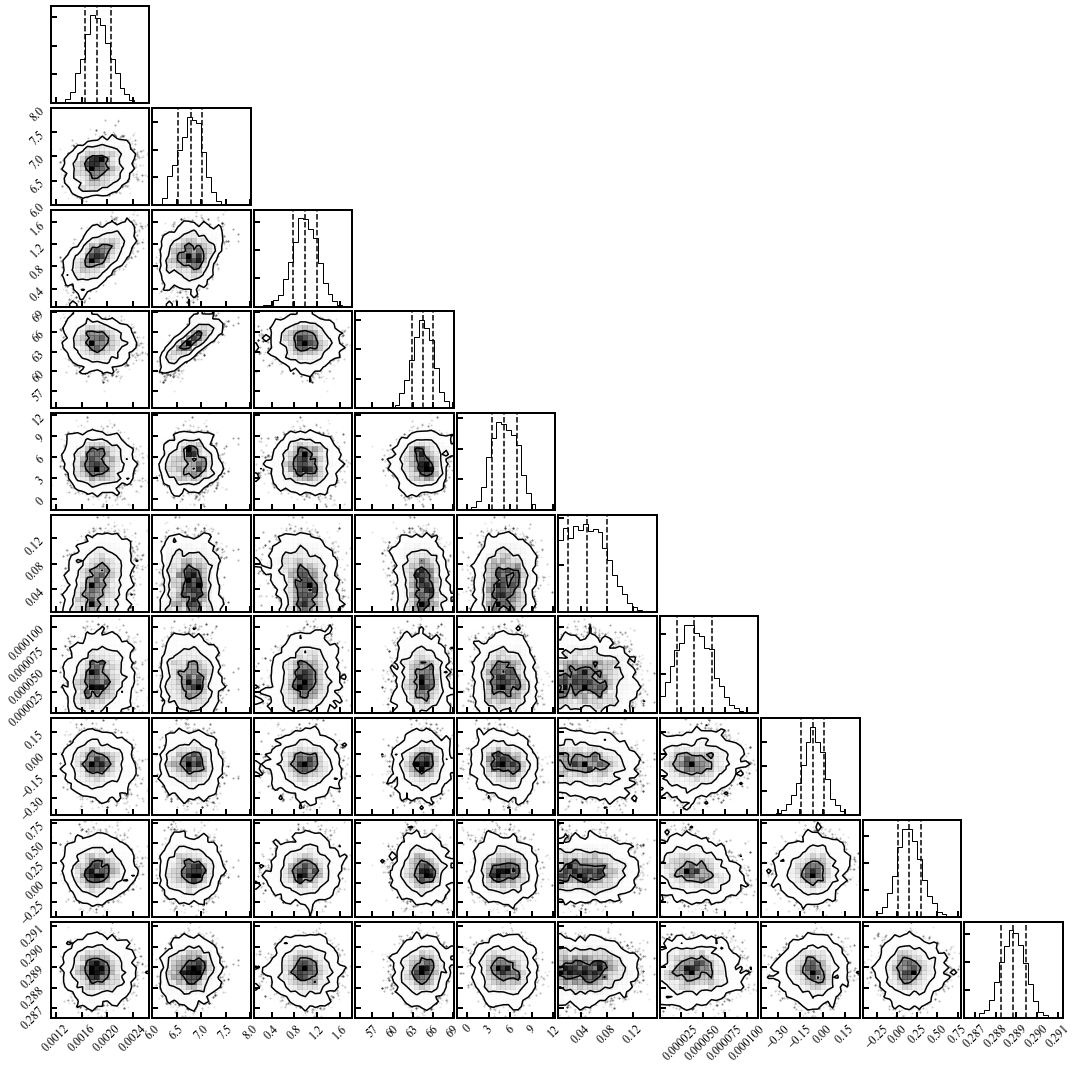

In [20]:
os.sys.path.append('/d1/boudica1/lmatra/corner-2.0.1')
import corner
import matplotlib

# Remove burn-in
samples=chain[burn:, :, :].reshape((-1, ndim))

# Make fonts smaller for corner plot
font={'family':'Times New Roman', 'size':16}	
matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=2)
matplotlib.rc('xtick.major', width=2, size=4)
matplotlib.rc('xtick.minor', width=2, size=4)
matplotlib.rc('ytick.major', width=2, size=4)
matplotlib.rc('ytick.minor', width=2, size=4)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rcParams.update({'figure.autolayout': True})


#Produce full corner with shifts and all
fig, ax=pl.subplots(ndim,ndim,figsize=(15,15), gridspec_kw={'wspace': 0.03}) #, labels=labelparams
corner.corner(samples, fig=fig, quantiles=[0.16, 0.50, 0.84], label_kwargs={'labelpad':20, 'fontsize':12}, show_titles=False, title_kwargs={'fontsize':12}, levels=1.0 - np.exp(-0.5 * (np.arange(3)+1.0) ** 2))
for i in np.arange(ndim):
	for j in np.arange(ndim):
		ax[i,j].tick_params(axis='both', direction='in', labelsize=12, length=6)
#pl.tight_layout()
